Dataset: https://www.kaggle.com/datasets/grassknoted/asl-alphabet

Source: https://www.kaggle.com/code/amin98hosseini/asl-classification-recognition-using-pytorch

In [1]:
# imports
import os
import kaggle


In [2]:
# dataset path
dataset_path = 'tmp'


In [3]:
# download dataset
if not os.path.exists(dataset_path + "asl_alphabet_train"):
    os.makedirs(dataset_path, exist_ok=True)

    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('grassknoted/asl-alphabet', path=dataset_path, unzip=True)


In [4]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision
from torch import nn
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, random_split


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import random
import os


In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [6]:
# Paths to your training and testing data
data_dir = dataset_path + '/asl_alphabet_train/asl_alphabet_train'
Val_dir = dataset_path + '/asl_alphabet_train/asl_alphabet_train'


In [7]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [8]:
# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=transform)


In [9]:
# Get class names
class_names = dataset.classes
num_classes = len(class_names)
class_names


['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [10]:
# Define the ratio for train/test split
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size


In [11]:
# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [12]:
# Get the number of samples in each set
num_train_samples = len(train_dataset)
num_test_samples = len(test_dataset)

print(f'Number of training samples: {num_train_samples}')
print(f'Number of testing samples: {num_test_samples}')


Number of training samples: 69600
Number of testing samples: 17400


In [13]:
num_classes = len(dataset.classes)
num_classes


29

In [14]:
# Create DataLoaders for training and testing sets
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


In [15]:
# Example of iterating over the training data
for images, labels in train_loader:
    # Your training code here
    print(images.shape, labels.shape)
    break

# Example of iterating over the testing data
for images, labels in test_loader:
    # Your testing code here
    print(images.shape, labels.shape)
    break


torch.Size([32, 3, 200, 200]) torch.Size([32])
torch.Size([32, 3, 200, 200]) torch.Size([32])


In [16]:
# Function to display random samples
def show_random_samples(dataset, class_names, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i in range(num_samples):
        random_idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[random_idx]
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C) for displaying
        axes[i].imshow(img)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


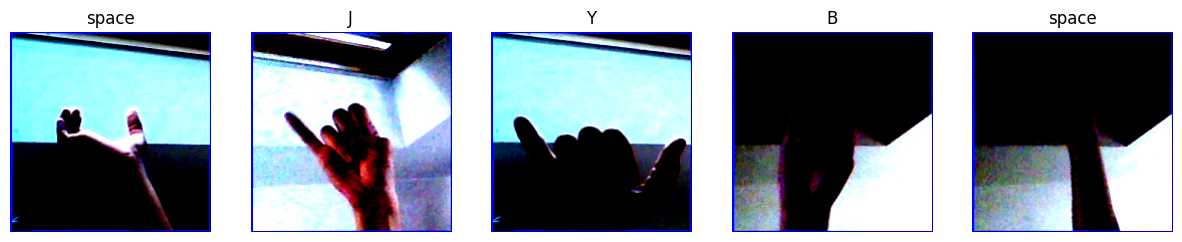

In [17]:
# Display random samples from the training set
show_random_samples(train_dataset, class_names)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


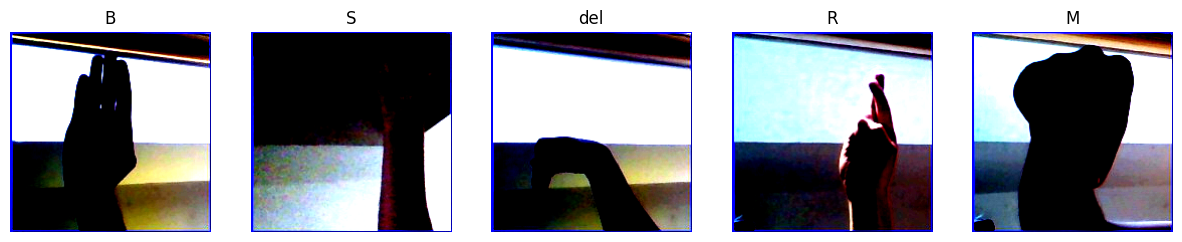

In [18]:
# Display random samples from the testing set
show_random_samples(test_dataset, class_names)


# My Simple Model

In [19]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=29):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.fc1 = nn.Linear(128 * 23 * 23, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 23 * 23)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [20]:
# Instantiate and move the model to the GPU
my_model = SimpleCNN(num_classes=num_classes).to(device)
# Define loss function and optimizer
my_model_criterion = nn.CrossEntropyLoss()
my_model_optimizer = optim.Adam(my_model.parameters(), lr=0.001)


In [21]:
summary(my_model, input_size=(3, 200, 200))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
         MaxPool2d-2           [-1, 32, 99, 99]               0
            Conv2d-3           [-1, 64, 97, 97]          18,496
         MaxPool2d-4           [-1, 64, 48, 48]               0
            Conv2d-5          [-1, 128, 46, 46]          73,856
         MaxPool2d-6          [-1, 128, 23, 23]               0
            Linear-7                  [-1, 512]      34,669,056
           Dropout-8                  [-1, 512]               0
            Linear-9                   [-1, 29]          14,877
Total params: 34,777,181
Trainable params: 34,777,181
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 20.27
Params size (MB): 132.66
Estimated Total Size (MB): 153.40
--------------------------------

# AlexNet Model

In [22]:
AlexNet_model = models.alexnet(pretrained=True)

# Freeze model parameters
for param in AlexNet_model.parameters():
    param.requires_grad = False


/home/rbrauner/data/workspace/studies/uekat-master-degree-studies-thesis/model/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rbrauner/data/workspace/studies/uekat-master-degree-studies-thesis/model/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
# Modify the last fully connected layer to fit your number of classes
AlexNet_model.classifier[6] = nn.Linear(4096, num_classes)

# Move the model to the device (GPU if available)
AlexNet_model.to(device)

# Define loss function and optimizer
AlexNet_model_criterion = nn.CrossEntropyLoss()
AlexNet_model_optimizer = optim.Adam(AlexNet_model.parameters(), lr=0.001)


In [24]:
summary(AlexNet_model, input_size=(3, 200, 200))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 49, 49]          23,296
              ReLU-2           [-1, 64, 49, 49]               0
         MaxPool2d-3           [-1, 64, 24, 24]               0
            Conv2d-4          [-1, 192, 24, 24]         307,392
              ReLU-5          [-1, 192, 24, 24]               0
         MaxPool2d-6          [-1, 192, 11, 11]               0
            Conv2d-7          [-1, 384, 11, 11]         663,936
              ReLU-8          [-1, 384, 11, 11]               0
            Conv2d-9          [-1, 256, 11, 11]         884,992
             ReLU-10          [-1, 256, 11, 11]               0
           Conv2d-11          [-1, 256, 11, 11]         590,080
             ReLU-12          [-1, 256, 11, 11]               0
        MaxPool2d-13            [-1, 256, 5, 5]               0
AdaptiveAvgPool2d-14            [-1, 25

# Vgg16 Model

In [25]:
# Load pre-trained VGG16 model
Vgg16_model = models.vgg16(pretrained=True)

# Freeze model parameters
for param in Vgg16_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to fit your number of classes
Vgg16_model.classifier[6] = nn.Linear(Vgg16_model.classifier[6].in_features, num_classes)

# Move the model to the device (GPU if available)
Vgg16_model.to(device)

# Define loss function and optimizer
Vgg16_model_criterion = nn.CrossEntropyLoss()
Vgg16_model_optimizer = optim.Adam(Vgg16_model.parameters(), lr=0.001)


/home/rbrauner/data/workspace/studies/uekat-master-degree-studies-thesis/model/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
summary(Vgg16_model, input_size=(3, 200, 200))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]           1,792
              ReLU-2         [-1, 64, 200, 200]               0
            Conv2d-3         [-1, 64, 200, 200]          36,928
              ReLU-4         [-1, 64, 200, 200]               0
         MaxPool2d-5         [-1, 64, 100, 100]               0
            Conv2d-6        [-1, 128, 100, 100]          73,856
              ReLU-7        [-1, 128, 100, 100]               0
            Conv2d-8        [-1, 128, 100, 100]         147,584
              ReLU-9        [-1, 128, 100, 100]               0
        MaxPool2d-10          [-1, 128, 50, 50]               0
           Conv2d-11          [-1, 256, 50, 50]         295,168
             ReLU-12          [-1, 256, 50, 50]               0
           Conv2d-13          [-1, 256, 50, 50]         590,080
             ReLU-14          [-1, 256,

# Vgg19 Model

In [27]:
# Load pre-trained VGG19 model
Vgg19_model = models.vgg19(pretrained=True)

# Freeze model parameters
for param in Vgg19_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to fit your number of classes
num_classes = len(dataset.classes)
Vgg19_model.classifier[6] = nn.Linear(Vgg19_model.classifier[6].in_features, num_classes)

# Move the model to the device (GPU if available)
Vgg19_model.to(device)

# Define loss function and optimizer
Vgg19_model_criterion = nn.CrossEntropyLoss()
Vgg19_model_optimizer = optim.Adam(Vgg19_model.parameters(), lr=0.001)


/home/rbrauner/data/workspace/studies/uekat-master-degree-studies-thesis/model/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
summary(Vgg19_model, input_size=(3, 200, 200))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]           1,792
              ReLU-2         [-1, 64, 200, 200]               0
            Conv2d-3         [-1, 64, 200, 200]          36,928
              ReLU-4         [-1, 64, 200, 200]               0
         MaxPool2d-5         [-1, 64, 100, 100]               0
            Conv2d-6        [-1, 128, 100, 100]          73,856
              ReLU-7        [-1, 128, 100, 100]               0
            Conv2d-8        [-1, 128, 100, 100]         147,584
              ReLU-9        [-1, 128, 100, 100]               0
        MaxPool2d-10          [-1, 128, 50, 50]               0
           Conv2d-11          [-1, 256, 50, 50]         295,168
             ReLU-12          [-1, 256, 50, 50]               0
           Conv2d-13          [-1, 256, 50, 50]         590,080
             ReLU-14          [-1, 256,

# GoogleNet Model

In [29]:
# Load pre-trained GoogleNet model
googlenet_model = models.googlenet(pretrained=True)

# Freeze model parameters
for param in googlenet_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to fit your number of classes
num_classes = len(dataset.classes)
#googlenet_model.fc = nn.Linear(googlenet_model.fc[6].in_features, num_classes)
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, num_classes)

# Move the model to the device (GPU if available)
googlenet_model.to(device)

# Define loss function and optimizer
googlenet_model_criterion = nn.CrossEntropyLoss()
googlenet_model_optimizer = optim.Adam(googlenet_model.parameters(), lr=0.001)


/home/rbrauner/data/workspace/studies/uekat-master-degree-studies-thesis/model/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
summary(googlenet_model, input_size=(3, 200, 200))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,408
       BatchNorm2d-2         [-1, 64, 100, 100]             128
       BasicConv2d-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]           4,096
       BatchNorm2d-6           [-1, 64, 50, 50]             128
       BasicConv2d-7           [-1, 64, 50, 50]               0
            Conv2d-8          [-1, 192, 50, 50]         110,592
       BatchNorm2d-9          [-1, 192, 50, 50]             384
      BasicConv2d-10          [-1, 192, 50, 50]               0
        MaxPool2d-11          [-1, 192, 25, 25]               0
           Conv2d-12           [-1, 64, 25, 25]          12,288
      BatchNorm2d-13           [-1, 64, 25, 25]             128
      BasicConv2d-14           [-1, 64,

# ResNet Model

In [31]:
# Load pre-trained Resnet model
resnet18_model = models.resnet18(pretrained=True)

# Freeze model parameters
for param in resnet18_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to fit your number of classes
num_classes = len(dataset.classes)
#googlenet_model.fc = nn.Linear(googlenet_model.fc[6].in_features, num_classes)
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, num_classes)

# Move the model to the device (GPU if available)
resnet18_model.to(device)

# Define loss function and optimizer
resnet18_model_criterion = nn.CrossEntropyLoss()
resnet18_model_optimizer = optim.Adam(resnet18_model.parameters(), lr=0.001)


/home/rbrauner/data/workspace/studies/uekat-master-degree-studies-thesis/model/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
summary(resnet18_model, input_size=(3, 200, 200))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,408
       BatchNorm2d-2         [-1, 64, 100, 100]             128
              ReLU-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]          36,864
       BatchNorm2d-6           [-1, 64, 50, 50]             128
              ReLU-7           [-1, 64, 50, 50]               0
            Conv2d-8           [-1, 64, 50, 50]          36,864
       BatchNorm2d-9           [-1, 64, 50, 50]             128
             ReLU-10           [-1, 64, 50, 50]               0
       BasicBlock-11           [-1, 64, 50, 50]               0
           Conv2d-12           [-1, 64, 50, 50]          36,864
      BatchNorm2d-13           [-1, 64, 50, 50]             128
             ReLU-14           [-1, 64,

# Train

In [33]:
# Training loop
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)
        epoch_loss /= len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    return epoch_loss


## My Model Training

In [34]:
# Train the model
my_model_loss=train_model(my_model, train_loader, my_model_criterion, my_model_optimizer, device, num_epochs=10)


Epoch 1/10, Loss: 1.0302
Epoch 2/10, Loss: 0.3211
Epoch 3/10, Loss: 0.2013
Epoch 4/10, Loss: 0.1435
Epoch 5/10, Loss: 0.1162
Epoch 6/10, Loss: 0.0931
Epoch 7/10, Loss: 0.0777
Epoch 8/10, Loss: 0.0778
Epoch 9/10, Loss: 0.0563
Epoch 10/10, Loss: 0.0555


In [35]:
torch.save(my_model, 'ASL_my_model_V1.0.1.pth')


## AlexNet Model Training

In [36]:
AlexNet_model_loss=train_model(AlexNet_model, train_loader, AlexNet_model_criterion, AlexNet_model_optimizer, device, num_epochs=10)


Epoch 1/10, Loss: 0.5955
Epoch 2/10, Loss: 0.3898
Epoch 3/10, Loss: 0.3569
Epoch 4/10, Loss: 0.3473
Epoch 5/10, Loss: 0.3477
Epoch 6/10, Loss: 0.3375
Epoch 7/10, Loss: 0.3303
Epoch 8/10, Loss: 0.3292
Epoch 9/10, Loss: 0.3216
Epoch 10/10, Loss: 0.3238


In [37]:
torch.save(AlexNet_model, 'ASL_AlexNet_model_V1.0.1.pth')


## Vgg16 Model Training

In [38]:
Vgg16_model_loss=train_model(Vgg16_model, train_loader, Vgg16_model_criterion, Vgg16_model_optimizer, device, num_epochs=10)


Epoch 1/10, Loss: 0.8347
Epoch 2/10, Loss: 0.5752
Epoch 3/10, Loss: 0.5479
Epoch 4/10, Loss: 0.5381
Epoch 5/10, Loss: 0.5256
Epoch 6/10, Loss: 0.5305
Epoch 7/10, Loss: 0.5189
Epoch 8/10, Loss: 0.5187
Epoch 9/10, Loss: 0.5265
Epoch 10/10, Loss: 0.5195


In [39]:
torch.save(Vgg16_model, 'ASL_Vgg16_model_V1.0.1.pth')


## Vgg19 Model Training

In [40]:
Vgg19_model_loss=train_model(Vgg19_model, train_loader, Vgg19_model_criterion, Vgg19_model_optimizer, device, num_epochs=10)


Epoch 1/10, Loss: 0.9048
Epoch 2/10, Loss: 0.6443
Epoch 3/10, Loss: 0.6068
Epoch 4/10, Loss: 0.5860
Epoch 5/10, Loss: 0.5855
Epoch 6/10, Loss: 0.5730
Epoch 7/10, Loss: 0.5657
Epoch 8/10, Loss: 0.5666
Epoch 9/10, Loss: 0.5689
Epoch 10/10, Loss: 0.5606


In [41]:
torch.save(Vgg19_model, 'ASL_Vgg19_model_V1.0.1.pth')


## GoogleNet Model Training

In [42]:
googlenet_model_loss=train_model(googlenet_model, train_loader, googlenet_model_criterion, googlenet_model_optimizer, device, num_epochs=10)


Epoch 1/10, Loss: 0.7913
Epoch 2/10, Loss: 0.3357
Epoch 3/10, Loss: 0.2706
Epoch 4/10, Loss: 0.2430
Epoch 5/10, Loss: 0.2258
Epoch 6/10, Loss: 0.2157
Epoch 7/10, Loss: 0.2098
Epoch 8/10, Loss: 0.2069
Epoch 9/10, Loss: 0.2018
Epoch 10/10, Loss: 0.2031


In [43]:
torch.save(googlenet_model, 'ASL_googlenet_model_V1.0.1.pth')


## ResNet Model Training

In [44]:
resnet18_model_loss=train_model(resnet18_model, train_loader, resnet18_model_criterion, resnet18_model_optimizer, device, num_epochs=10)


Epoch 1/10, Loss: 0.8154
Epoch 2/10, Loss: 0.3033
Epoch 3/10, Loss: 0.2218
Epoch 4/10, Loss: 0.1814
Epoch 5/10, Loss: 0.1574
Epoch 6/10, Loss: 0.1407
Epoch 7/10, Loss: 0.1291
Epoch 8/10, Loss: 0.1204
Epoch 9/10, Loss: 0.1100
Epoch 10/10, Loss: 0.1058


In [45]:
torch.save(resnet18_model, 'ASL_resnet18_model_V1.0.1.pth')


In [46]:
model_losses = {
    "My Model": my_model_loss,
    "AlexNet": AlexNet_model_loss,
    "Vgg16": Vgg16_model_loss,
    "Vgg19": Vgg19_model_loss,
    "GoogLeNet": googlenet_model_loss,
    "ResNet18": resnet18_model_loss
}


In [47]:
df = pd.DataFrame.from_dict(model_losses, orient='index', columns=['Loss'])


In [48]:
print(df.to_string())


               Loss
My Model   0.055506
AlexNet    0.323849
Vgg16      0.519494
Vgg19      0.560595
GoogLeNet  0.203097
ResNet18   0.105833


# Evaluation

In [49]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy


In [50]:
# Test the model
my_model_accuracy=test_model(my_model, test_loader, my_model_criterion, device)


Test Accuracy: 99.55%


In [51]:
# Test the model
AlexNet_model_accuracy=test_model(AlexNet_model, test_loader, AlexNet_model_criterion, device)


Test Accuracy: 97.88%


In [52]:
# Test the model
Vgg16_model_accuracy=test_model(Vgg16_model, test_loader, Vgg16_model_criterion, device)


Test Accuracy: 96.82%


In [59]:
# Test the model
Vgg19_model_accuracy=test_model(Vgg19_model, test_loader, Vgg19_model_criterion, device)


Test Accuracy: 94.83%


In [53]:
# Test the model
googlenet_model_accuracy=test_model(googlenet_model, test_loader, googlenet_model_criterion, device)


Test Accuracy: 97.67%


In [54]:
# Test the model
resnet18_model_accuracy=test_model(resnet18_model, test_loader, resnet18_model_criterion, device)


Test Accuracy: 97.54%


In [62]:
# Create a dictionary to store results
model_results = {
    "Model": ["My Model", "AlexNet", "Vgg16", "Vgg19", "GoogLeNet", "ResNet18"],
    "Loss": [my_model_loss, AlexNet_model_loss, Vgg16_model_loss, Vgg19_model_loss, googlenet_model_loss, resnet18_model_loss],
    "Accuracy": [my_model_accuracy, AlexNet_model_accuracy, Vgg16_model_accuracy, Vgg19_model_accuracy, googlenet_model_accuracy, resnet18_model_accuracy]
}

# Create a Pandas DataFrame from the dictionary
df = pd.DataFrame(model_results)

# Print the DataFrame as a table
print(df.to_string())


       Model      Loss   Accuracy
0   My Model  0.055506  99.545977
1    AlexNet  0.323849  97.879310
2      Vgg16  0.519494  96.821839
3      Vgg19  0.560595  94.833333
4  GoogLeNet  0.203097  97.666667
5   ResNet18  0.105833  97.540230


# Visualization

In [63]:
# if you need load saved model use this
MyModel = SimpleCNN()  # Define your model
MyModel = torch.load('ASL_my_model_V1.0.1.pth')
MyModel = MyModel.to(device)


In [88]:
def predict_and_display_image(model, image_path, transform, device):
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Preprocess the image
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Make a prediction
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    # Display the image and prediction
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class} - {model.__class__.__name__}")
    plt.axis('off')
    plt.show()


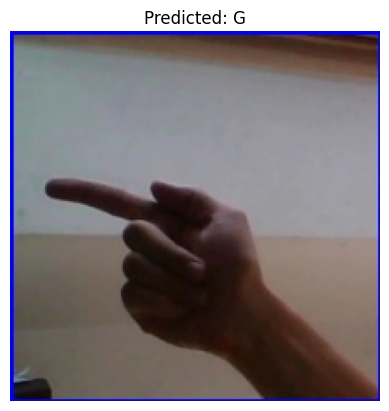

In [72]:
image_path = 'tmp/asl_alphabet_test/asl_alphabet_test/G_test.jpg'
predict_and_display_image(my_model, image_path, transform, device)


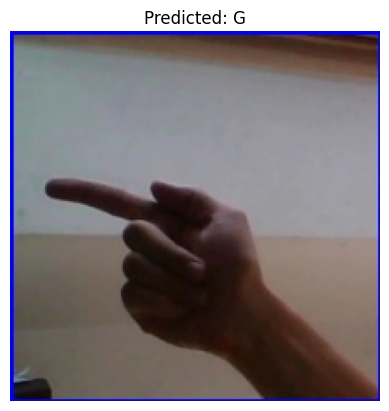

In [73]:
image_path = 'tmp/asl_alphabet_test/asl_alphabet_test/G_test.jpg'
predict_and_display_image(AlexNet_model, image_path, transform, device)


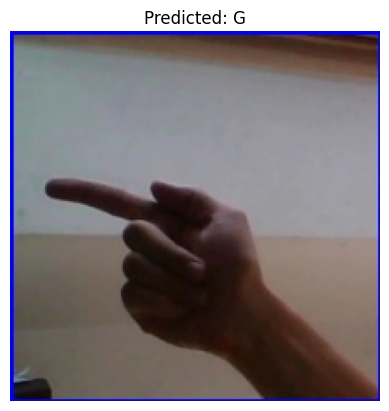

In [74]:
image_path = 'tmp/asl_alphabet_test/asl_alphabet_test/G_test.jpg'
predict_and_display_image(Vgg16_model, image_path, transform, device)


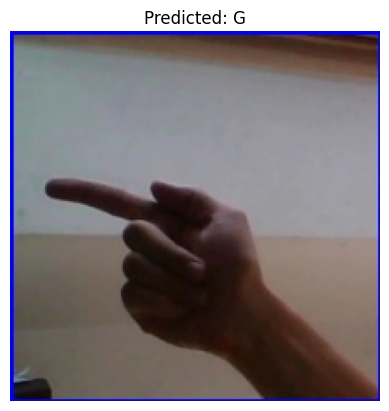

In [75]:
image_path = 'tmp/asl_alphabet_test/asl_alphabet_test/G_test.jpg'
predict_and_display_image(Vgg19_model, image_path, transform, device)


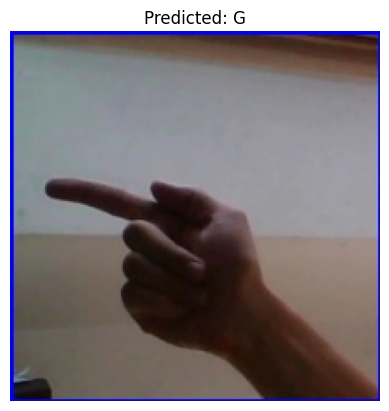

In [76]:
image_path = 'tmp/asl_alphabet_test/asl_alphabet_test/G_test.jpg'
predict_and_display_image(googlenet_model, image_path, transform, device)


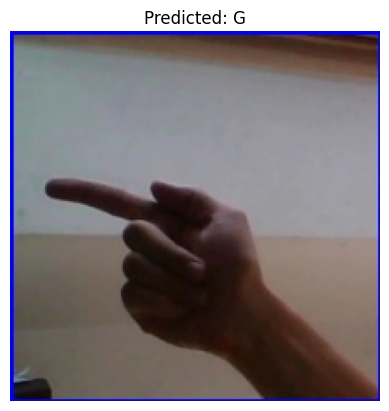

In [77]:
image_path = 'tmp/asl_alphabet_test/asl_alphabet_test/G_test.jpg'
predict_and_display_image(resnet18_model, image_path, transform, device)


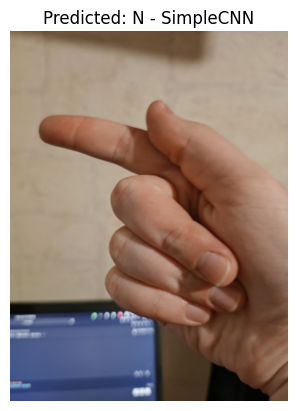

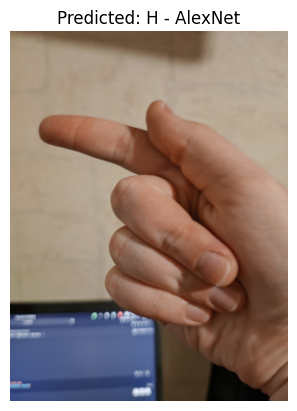

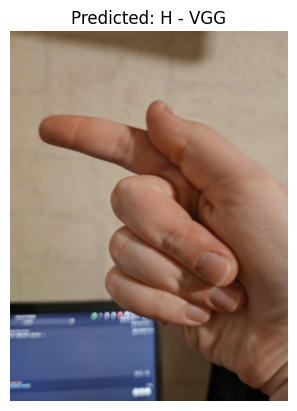

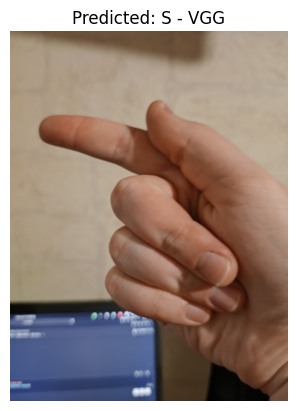

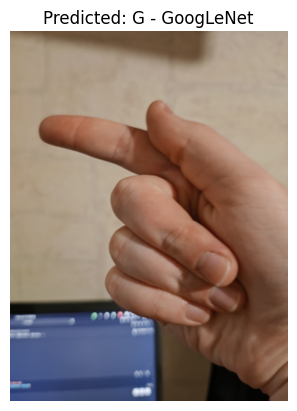

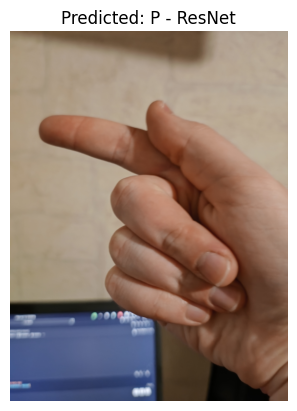

In [89]:
image_path = 'tmp/test_g.jpeg'

for model in [my_model, AlexNet_model, Vgg16_model, Vgg19_model, googlenet_model, resnet18_model]:
    predict_and_display_image(model, image_path, transform, device)
